In [32]:
from src.datasets.tabular import ADULT, BRFSS, CANDC, COMPAS, GERMAN
import os
dataset = COMPAS
output_path = 'results/' + dataset
filename = dataset + '.csv'

Below are the holistic analysis code of the experiment result.

In [27]:
#find the best config (min avg loss) of each model with its idx, cumu_loss, avg_loss, worst_avg_loss, loss_parity, group_action_parity
import pandas as pd
import os 
import json, ast
filename = dataset + '_summary.csv'
df = pd.read_csv(os.path.join(output_path, filename))
df = df.rename(columns = {'Unnamed: 0': 'seq_id'})
regret_model = list(set(df['model']))
best_results = []
for model_name in regret_model:
    df_select = df[df['model'] == model_name]
    #find its config
    df_select.sort_values('avg_loss', inplace = False)
    best_metric = df_select.iloc[-1]
    config = ast.literal_eval(best_metric['config'])
    if model_name == 'supervised':
        idx = 0
    else:
        idx = config['idx']
    eval_metric = {'model': model_name, 'idx': idx, 'loss': best_metric['avg_loss'], 'group_loss_parity': best_metric['loss_parity'],
                    'group_action_parity': best_metric['group_action_parity_realized'], 'ind_parity': best_metric['individual_loss_parity_realized']}
    eval_metric.update({'worst_group_loss': max([best_metric[column] for column in best_metric.index if column.startswith('avg_loss_')])})

    best_results.append(eval_metric)
df_summary2 = pd.DataFrame(best_results)
output_file = os.path.join(output_path, dataset + '_summary_best.csv')
df_summary2.to_csv(output_file, index = None)

<Figure size 2000x2000 with 0 Axes>

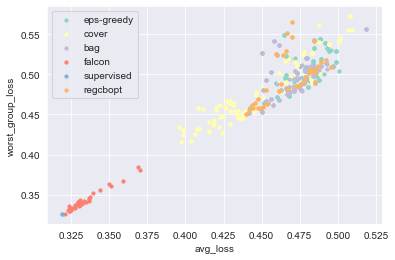

<Figure size 2000x2000 with 0 Axes>

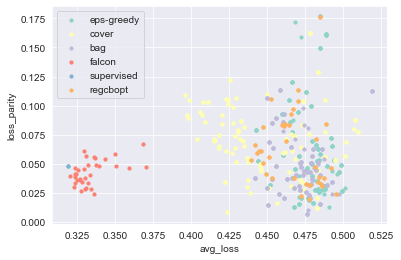

<Figure size 2000x2000 with 0 Axes>

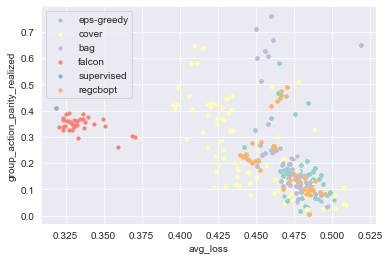

<Figure size 2000x2000 with 0 Axes>

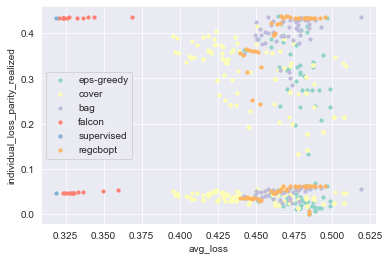

In [34]:
#(TODO): scatter plot of all results showing the trend of regret and some fairness metric
import pandas as pd
import os 
import json, ast
import matplotlib.pyplot as plt
import seaborn as sns

from src.datasets.tabular import ADULT, BRFSS, CANDC, COMPAS, GERMAN
dataset = COMPAS
output_path = 'results/' + dataset
filename = dataset + '_summary.csv'
df = pd.read_csv(os.path.join(output_path, filename))
def scatter(df, xname, yname):
    df = df.rename(columns = {'Unnamed: 0': 'seq_id'})
    regret_model = list(set(df['model']))
    best_results = []
    column_list = [column for column in df.columns if column.startswith('avg_loss_')]

    plt.figure(figsize = (20, 20), dpi = 100)
    sns.set_style('darkgrid')
    df['worst_group_loss'] = df.loc[:, column_list].T.max()

    # color list: https://gist.github.com/jsundram/6004447
    
    df_select  = df[df['model'] == regret_model[0]]

    color_list = ["#8dd3c7","#ffffb3","#bebada","#fb8072","#80b1d3","#fdb462","#b3de69","#fccde5"]
    #["#ffffe5","#f7fcb9","#d9f0a3","#addd8e","#78c679","#41ab5d","#238443","#005a32"]
    ax0 = df_select.plot.scatter(x = xname, y = yname, s = 10,
                                color = color_list[0], label = regret_model[0])
    for i, model_name in enumerate(regret_model[1:]):
        df_select = df[df['model'] == model_name]
        
        ax0 = df_select.plot.scatter(x = xname, y = yname, s = 10,
                                    color = color_list[i + 1], label = model_name, ax = ax0)
    #plt.savefig('test.pdf')
## Figure 1: loss vs worst-group loss
scatter(df, 'avg_loss', 'worst_group_loss')
## Figure 2: loss vs loss_parity
scatter(df, 'avg_loss', 'loss_parity')
scatter(df, 'avg_loss', 'group_action_parity_realized')
## Figure 3: loss vs ind-parity
scatter(df, 'avg_loss', 'individual_loss_parity_realized')


In [3]:
df

,seq_id,model,config,cumu_loss,avg_loss,cumu_loss_0,avg_loss_0,cumu_loss_1,avg_loss_1,cumu_loss_2,avg_loss_2,cumu_loss_3,avg_loss_3,loss_parity,group_action_parity_realized,individual_loss_parity_realized
0,0.0,falcon,"{'gamma_param': 20, 'idx': 0}",2137.003,0.370300,1167.0,0.371065,574.001,0.380133,151.001,0.332601,245.001,0.370092,0.047532,0.297824,NaN
1,1.0,falcon,"{'gamma_param': 40, 'idx': 1}",2025.003,0.350893,1136.0,0.361208,534.001,0.353643,142.001,0.312777,213.001,0.321753,0.048431,0.340337,NaN
2,2.0,falcon,"{'gamma_param': 60, 'idx': 2}",1931.003,0.334605,1072.0,0.340859,507.001,0.335762,142.001,0.312777,210.001,0.317222,0.028082,0.368448,NaN
3,3.0,falcon,"{'gamma_param': 80, 'idx': 3}",1944.003,0.336857,1088.0,0.345946,521.001,0.345034,132.001,0.290750,203.001,0.306648,0.055195,0.333845,NaN
4,4.0,falcon,"{'gamma_param': 100, 'idx': 4}",1948.003,0.337550,1074.0,0.341494,523.001,0.346358,135.001,0.297358,216.001,0.326285,0.049000,0.355872,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,NaN,bag,"{'learning_rate': 1, 'cb_type': 'ips', 'bag': ...",2791.003,0.483626,1524.0,0.484579,734.001,0.486093,203.001,0.447138,330.001,0.498490,0.051352,0.117038,0.429770
379,NaN,bag,"{'learning_rate': 1, 'cb_type': 'mtr', 'bag': ...",2688.003,0.465778,1518.0,0.482671,668.001,0.442384,190.001,0.418503,312.001,0.471300,0.064167,0.258894,0.317810
380,NaN,bag,"{'learning_rate': 1, 'cb_type': 'mtr', 'bag': ...",2631.003,0.455901,1475.0,0.468998,670.001,0.443709,191.001,0.420706,295.001,0.445620,0.048292,0.238299,0.377798
381,NaN,bag,"{'learning_rate': 1, 'cb_type': 'mtr', 'bag': ...",2724.003,0.472016,1425.0,0.453100,747.001,0.494702,218.001,0.480177,334.001,0.504532,0.051432,0.197147,0.299690


In [50]:
max([best_metric[column] for column in best_metric.index if column.startswith('avg_loss_')])

0.2719307395431313

Below are the individual analysis step of each algorithm.

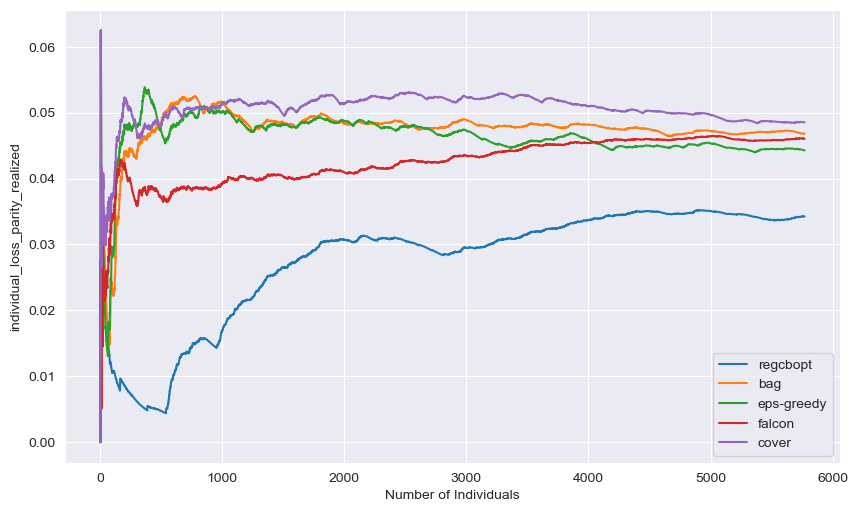

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
metric = 'individual_loss_parity_realized'
idx = 0
df = pd.read_csv(os.path.join(output_path, dataset + '_summary_best.csv'))

method_list = list(df['model'])
idx_list = list(df['idx'])
plt.figure(figsize = (10, 6), dpi = 100)
sns.set_style('darkgrid')

for i in range(len(method_list)):
    if method_list[i] == 'supervised':
        continue
    filename = dataset + '_' + method_list[i] + '_' + str(idx_list[i]) + '.csv'
    df = pd.read_csv(os.path.join(output_path, filename))
    df = df.rename(columns = {'Unnamed: 0': 'time'})
    if metric == 'worst-group-loss':
        loss_list = [column for column in df.columns if column.startswith('cumu_loss_')]
        df[metric] = df.loc[:,loss_list].T.max()
    elif metric in ['cumu_loss', 'loss_parity', 'group_action_parity_realized', 'individual_loss_parity_realized']:
        pass
    else:
        pass
    plt.plot(list(df['time']), list(df[metric]), label = method_list[i])
plt.xlabel('Number of Individuals')
plt.ylabel(metric)
plt.legend()
#plt.savefig()
plt.show()
# if metric == 'worst_group_loss':
#     pass

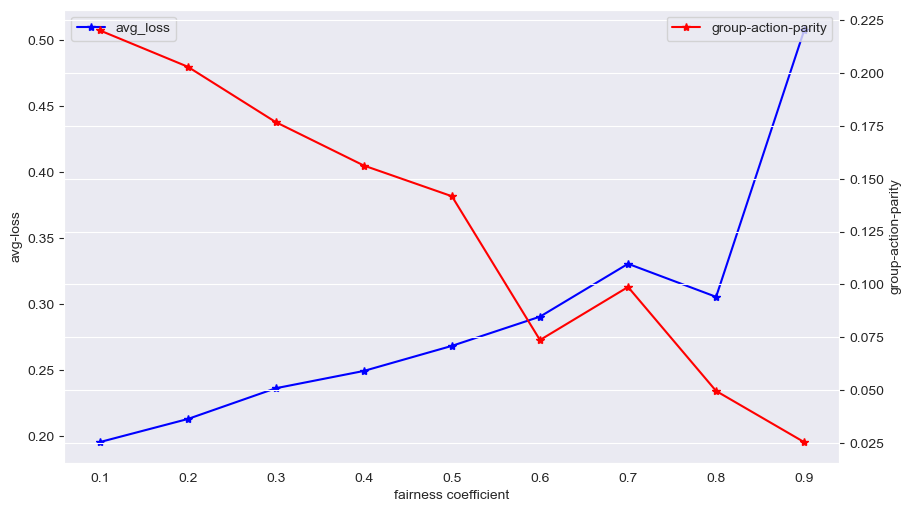

In [15]:
# SHOW THE TREND FOR REGRET W.R.T. UNFAIRNESS individual-parity, group-action-parity
from src.datasets.tabular import ADULT, BRFSS, CANDC, COMPAS, GERMAN
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
dataset = ADULT
output_path = 'results/' + dataset
fair_type = 'group-action-parity'
fair_label_dict = {'individual-parity': 'individual_loss_parity_realized', 
                    'group-action-parity': 'group_action_parity_realized'}
filename = dataset + '_summary_' + fair_type + '.csv'
df = pd.read_csv(os.path.join(output_path, filename))
fig = plt.figure(figsize = (10, 6), dpi = 100)
sns.set_style('darkgrid')
ax = fig.add_subplot(111)
ax.grid()
ax.plot(df['ind_parity'], df['avg_loss'], color = 'blue', marker = '*', label = 'avg_loss')
ax.legend(loc = 'upper left')

ax2 = ax.twinx()
ax2.plot(df['ind_parity'], df[fair_label_dict[fair_type]], color = 'red', marker = '*', label = fair_type)
ax.set_xlabel('fairness coefficient')
ax.set_ylabel('avg-loss')
ax2.set_ylabel(fair_type)
ax2.legend(loc = 'upper right')

plt.show()



In [38]:
#show the aggregated result of imposing worst group loss constraint
from src.datasets.tabular import ADULT, BRFSS, CANDC, COMPAS, GERMAN
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
dataset = COMPAS
output_path = 'results/' + dataset

filename = dataset + '_summary_loss.csv'
df = pd.read_csv(os.path.join(output_path, filename))
# fig = plt.figure(figsize = (10, 6), dpi = 100)
# sns.set_style('darkgrid')

column_list = [column for column in df.columns if column.startswith('avg_loss_')]
df['worst_group_loss'] = df.loc[:, column_list].T.max()
df = df.fillna(0)
df.groupby(['gamma', 'fair_loss_type'])[['avg_loss', 'loss_parity', 'worst_group_loss', 'individual_loss_parity_realized']].mean()

avg_loss  loss_parity  worst_group_loss  \
gamma fair_loss_type                                                   
50    0                      0.343347     0.044094          0.352426   
      history-group-weight   0.345374     0.039174          0.355015   
      history-group-weight2  0.344412     0.047655          0.353650   
100   0                      0.333833     0.042905          0.342624   
      history-group-weight   0.332135     0.039059          0.340705   
      history-group-weight2  0.333461     0.040890          0.342491   
150   0                      0.328930     0.036469          0.336480   
      history-group-weight   0.329943     0.038089          0.338754   
      history-group-weight2  0.329094     0.042555          0.338031   
200   0                      0.326694     0.039492          0.335112   
      history-group-weight   0.327422     0.037574          0.336068   
      history-group-weight2  0.327708     0.034332          0.336435   
250   0                      0.325377     0.037992          0.333809   
      history-group-weight   0.325083     0.035567          0.333000   
      history-group-weight2  0.325213     0.041331          0.333990   
300   0                      0.324450     0.036435          0.332420   
      history-group-weight   0.324164     0.036588          0.332715   
      history-group-weight2  0.324520     0.039848          0.333589   

                             individual_loss_parity_realized  
gamma fair_loss_type                                          
50    0                                             0.050405  
      history-group-weight                          0.050473  
      history-group-weight2                         0.050356  
100   0                                             0.047902  
      history-group-weight                          0.048146  
      history-group-weight2                         0.048349  
150   0                                             0.046917  
      history-group-weight                          0.047259  
      history-group-weight2                         0.047331  
200   0                                             0.046680  
      history-group-weight                          0.046624  
      history-group-weight2                         0.046679  
250   0                                             0.046118  
      history-group-weight                          0.046194  
      history-group-weight2                         0.046352  
300   0                                             0.045771  
      history-group-weight                          0.046017  
      history-group-weight2                         0.046210